# Calculate the path averaged radar reference along each CML of the openMRG dataset

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import opensense_data_downloader_and_transformer as oddt
import pycomlink as pycml
import xarray as xr
import pyproj
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Get CML (metadata) data

In [2]:
# function from OpenSense sandbox https://github.com/OpenSenseAction/OPENSENSE_sandbox/blob/main/notebooks/Explore_existing_datasets.ipynb
oddt.download_andersson_2022_OpenMRG(
    local_path="data/andersson_2022_OpenMRG/", print_output=True
)

File already exists at desired location data/andersson_2022_OpenMRG/OpenMRG.zip
Not downloading!


In [3]:
#### function from sandbox
ds_cml = oddt.transform_andersson_2022_OpenMRG(
    fn="data/andersson_2022_OpenMRG/OpenMRG.zip",
    path_to_extract_to="data/andersson_2022_OpenMRG/",
    time_start_end=(
        "2015-08-31",
        None,
    ),  # default (None, None) -> no timeslicing. ie. ('2015-08-31T00', None),
    restructure_data=True,
)

/bg/home/graf-m/notebooks/cml_method_comparison/waa_comparison/opensense_data_downloader_and_transformer.py:302: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'sublink' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  ds_multindex = ds.assign_coords({'sublink':df_metadata.index})


#### Get radar data

In [10]:
ds_radar = xr.open_dataset(
    "data/andersson_2022_OpenMRG/radar/radar.nc"
)
# get rain rates from radar reflecitivity
ds_radar["dBZ"] = 0.4 * ds_radar.data - 30
ds_radar["R"] = (10 ** (ds_radar.data / 10) / 200) ** (5 / 8)

#add lon lat grid
x_grid, y_grid = np.meshgrid(ds_radar.x.values, ds_radar.y.values)
transformer = pyproj.Transformer.from_crs(
    "+proj=stere +lat_ts=60 +ellps=bessel +lon_0=14 +lat_0=90",
    "EPSG:4326",
    always_xy=True,
)
lon_grid, lat_grid = transformer.transform(xx=x_grid, yy=y_grid)

ds_radar.coords["lon"] = (("y", "x"), lon_grid)
ds_radar.coords["lat"] = (("y", "x"), lat_grid)

#### Get radar along CML paths

In [11]:
ds_radar

<xarray.Dataset>
Dimensions:  (time: 26496, x: 37, y: 48)
Coordinates:
  * time     (time) datetime64[ns] 2015-06-01T00:05:00 ... 2015-09-01
  * x        (x) float64 -1.542e+05 -1.522e+05 ... -8.42e+04 -8.22e+04
  * y        (y) float64 -3.413e+06 -3.415e+06 ... -3.505e+06 -3.507e+06
    lat      (y, x) float64 58.04 58.04 58.04 58.04 ... 57.23 57.23 57.23 57.23
    lon      (y, x) float64 11.41 11.45 11.48 11.51 ... 12.56 12.59 12.62 12.66
Data variables:
    crs      int32 ...
    data     (time, y, x) float64 nan nan nan nan nan ... 36.0 36.8 40.0 36.4
    dBZ      (time, y, x) float64 nan nan nan nan ... -15.6 -15.28 -14.0 -15.44
    R        (time, y, x) float64 nan nan nan nan ... 6.484 7.275 11.53 6.868
Attributes:
    source:       Swedish Meteorological and Hydrological Institute (SMHI), H...
    contact:      hydro.fou@smhi.se, remco.vandebeek@smhi.se
    title:        OpenMRG-Radar
    license:      https://creativecommons.org/licenses/by-sa/4.0
    version:      1.1
    doi:          https://doi.org/10.5281/zenodo.6673750
    proj_string:  +proj=stere +lat_ts=60 +ellps=bessel +lon_0=14 +lat_0=90
    comment:      Created by Remco van de Beek, Victor Näslund and Johan Thur...

In [15]:
da_intersect_weights = pycml.spatial.grid_intersection.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cml.site_0_lon.values,
    y1_line=ds_cml.site_0_lat.values,
    x2_line=ds_cml.site_1_lon.values,
    y2_line=ds_cml.site_1_lat.values,
    cml_id=ds_cml.cml_id.values,
    x_grid=ds_radar.lon.values,
    y_grid=ds_radar.lat.values,
    grid_point_location='center',
)
da_radar_along_cmls = pycml.spatial.grid_intersection.get_grid_time_series_at_intersections(
    grid_data=ds_radar.R,
    intersect_weights=da_intersect_weights,
)

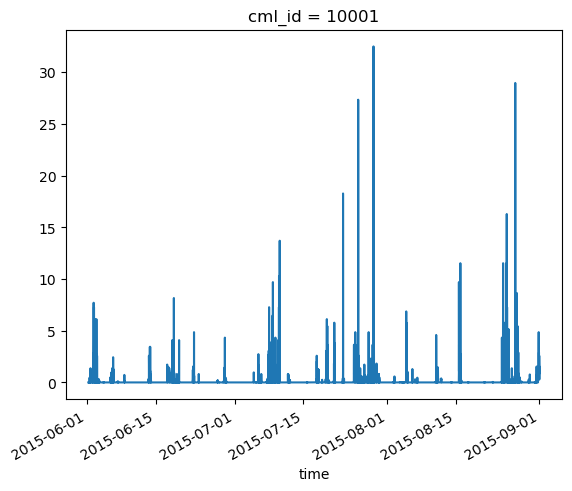

In [23]:
da_radar_along_cmls.isel(cml_id=0).plot();

In [25]:
da_radar_along_cmls.isel(cml_id=0).sum(dim='time')/12

<xarray.DataArray ()>
array(203.2007191)
Coordinates:
    cml_id   int64 10001

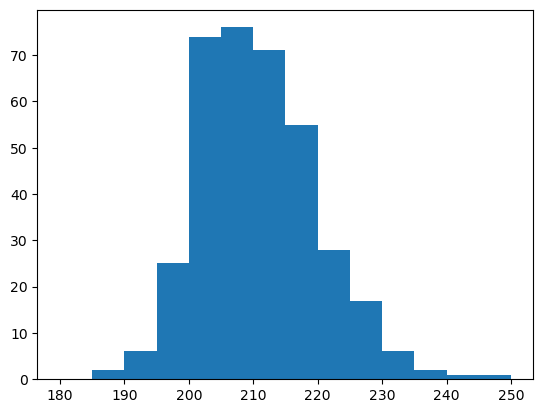

In [36]:
(da_radar_along_cmls.sum(dim='time')/12).plot.hist(bins=np.linspace(180,250,15));


In [41]:
da_radar_along_cmls=da_radar_along_cmls.to_dataset(name='rainfall_amount')

In [42]:
da_radar_along_cmls.to_netcdf('data/andersson_2022_OpenMRG/radar/radar_along_cml.nc')